- 세그먼트 : 이미지를 여러개의 영역으로 나누는 작업으로 컴퓨터의 비전 및 이미지 처리에 사용
  - 이진 세그먼트
  - 다중 클래스 세그먼트
  - 인스턴스 세그먼트
    - 같은 클래스의 객체를 개별적으로 구분
  - 파노라믹 세그먼트
    - 인스턴스 세그먼트와 픽셀 분류의 조합, 모든 픽셀을 객체로 할당하거나 배경으로 분류

참고 자료 : https://www.tensorflow.org/tutorials/images/segmentation?hl=ko

In [1]:
import tensorflow as tf
data_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
data_dir = tf.keras.utils.get_file(origin=data_url, extract=True)

791918971/791918971 ━━━━━━━━━━━━━━━━━━━━ 42s 0us/step


In [2]:
import tarfile
import os
# Extract the .tar.gz file manually
if data_dir.endswith('.tar.gz'):
    # Open the downloaded .tar.gz file and extract it
    with tarfile.open(data_dir, "r:gz") as tar_ref:
        tar_ref.extractall(os.path.dirname(data_dir))

    # Check where the data was extracted
    extracted_dir = os.path.join(os.path.dirname(data_dir), 'images')
    print(f"Data extracted to: {extracted_dir}")
else:
    print("The downloaded file is not in the correct format.")

Data extracted to: /root/.keras/datasets/images


In [3]:
os.listdir(extracted_dir)

['english_setter_171.jpg',
 'pomeranian_27.jpg',
 'Ragdoll_170.jpg',
 'Bombay_18.jpg',
 'american_pit_bull_terrier_106.jpg',
 'american_pit_bull_terrier_31.jpg',
 'english_setter_13.jpg',
 'samoyed_114.jpg',
 'american_bulldog_37.jpg',
 'english_setter_78.jpg',
 'Russian_Blue_154.jpg',
 'great_pyrenees_132.jpg',
 'pomeranian_44.jpg',
 'Sphynx_40.jpg',
 'keeshond_161.jpg',
 'Bengal_185.jpg',
 'Ragdoll_141.jpg',
 'Bengal_12.jpg',
 'Russian_Blue_19.jpg',
 'american_pit_bull_terrier_92.jpg',
 'Birman_38.jpg',
 'boxer_9.jpg',
 'shiba_inu_35.jpg',
 'British_Shorthair_273.jpg',
 'wheaten_terrier_176.jpg',
 'staffordshire_bull_terrier_140.jpg',
 'Persian_102.jpg',
 'British_Shorthair_266.jpg',
 'British_Shorthair_104.jpg',
 'english_cocker_spaniel_100.jpg',
 'saint_bernard_24.jpg',
 'beagle_108.jpg',
 'havanese_198.jpg',
 'chihuahua_91.jpg',
 'Persian_82.jpg',
 'saint_bernard_127.jpg',
 'shiba_inu_51.jpg',
 'staffordshire_bull_terrier_38.jpg',
 'havanese_110.jpg',
 'Ragdoll_228.jpg',
 'Bombay_

In [4]:
data_url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
data_dir = tf.keras.utils.get_file(origin=data_url, extract=True)
import tarfile
import os
# Extract the .tar.gz file manually
if data_dir.endswith('.tar.gz'):
    # Open the downloaded .tar.gz file and extract it
    with tarfile.open(data_dir, "r:gz") as tar_ref:
        tar_ref.extractall(os.path.dirname(data_dir))

    # Check where the data was extracted
    extracted_dir_annotations = os.path.join(os.path.dirname(data_dir), 'annotations')
    print(f"Data extracted to: {extracted_dir_annotations}")
else:
    print("The downloaded file is not in the correct format.")

19173078/19173078 ━━━━━━━━━━━━━━━━━━━━ 105s 5us/step
Data extracted to: /root/.keras/datasets/annotations


In [5]:
os.listdir(extracted_dir_annotations+'/trimaps')

['._Birman_7.png',
 'havanese_148.png',
 '._staffordshire_bull_terrier_154.png',
 '._pug_172.png',
 '._Persian_264.png',
 'shiba_inu_19.png',
 '._saint_bernard_25.png',
 'english_setter_69.png',
 '._Russian_Blue_45.png',
 '._yorkshire_terrier_81.png',
 'havanese_103.png',
 '._american_bulldog_191.png',
 'Bombay_150.png',
 'samoyed_131.png',
 'great_pyrenees_2.png',
 'keeshond_143.png',
 '._Bengal_93.png',
 '._german_shorthaired_84.png',
 '._american_pit_bull_terrier_202.png',
 'leonberger_155.png',
 'yorkshire_terrier_53.png',
 '._wheaten_terrier_115.png',
 'Sphynx_89.png',
 'Siamese_231.png',
 'Maine_Coon_101.png',
 'boxer_134.png',
 'wheaten_terrier_127.png',
 'Persian_103.png',
 'Sphynx_165.png',
 'Abyssinian_133.png',
 '._Bombay_136.png',
 'leonberger_66.png',
 'pomeranian_69.png',
 'keeshond_8.png',
 '._Persian_95.png',
 'boxer_133.png',
 'Bengal_164.png',
 '._British_Shorthair_62.png',
 '._japanese_chin_96.png',
 'Bombay_75.png',
 '._basset_hound_138.png',
 'Russian_Blue_140.png'

In [6]:
input_dir = extracted_dir
target_dir = extracted_dir_annotations+'/trimaps'
img_size = (160,160)
num_classes = 4
batch_size = 32
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [7]:
print(len(input_img_paths), len(target_img_paths))

7390 7390


In [8]:
[ (input_path, target_path) for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10])]

[('/root/.keras/datasets/images/Abyssinian_1.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_1.png'),
 ('/root/.keras/datasets/images/Abyssinian_10.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_10.png'),
 ('/root/.keras/datasets/images/Abyssinian_100.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_100.png'),
 ('/root/.keras/datasets/images/Abyssinian_101.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_101.png'),
 ('/root/.keras/datasets/images/Abyssinian_102.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_102.png'),
 ('/root/.keras/datasets/images/Abyssinian_103.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_103.png'),
 ('/root/.keras/datasets/images/Abyssinian_104.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_104.png'),
 ('/root/.keras/datasets/images/Abyssinian_105.jpg',
  '/root/.keras/datasets/annotations/trimaps/Abyssinian_105.png'),
 ('/root/.keras/datasets/images/Abyssinian_106

이미지확인

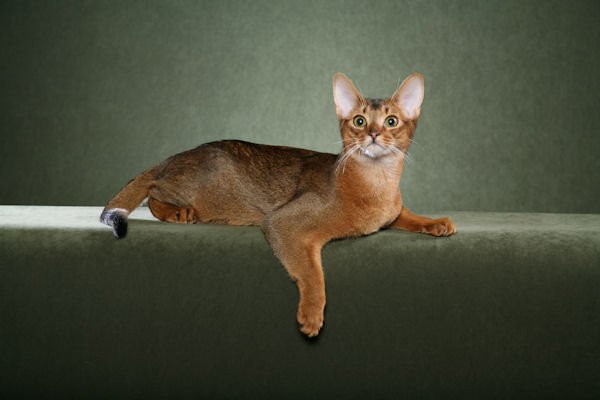

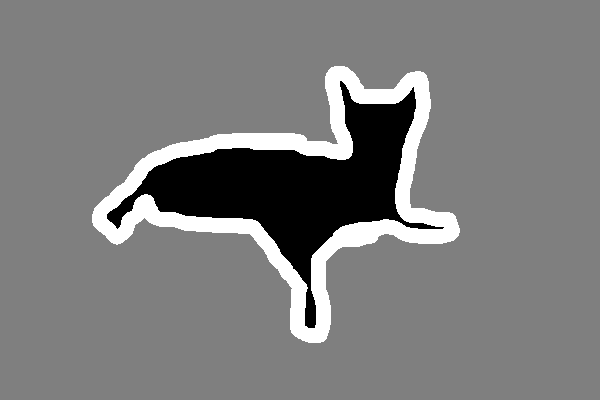

In [9]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[0]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)

In [10]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size,
                           color_mode='grayscale')
            y[j] = np.expand_dims(img, 2)
        return x, y

In [11]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        # Project residual
        residual = layers.Conv2D(
            filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(
        num_classes, 3, activation='sigmoid', padding='same')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [12]:
# refresh RAM
keras.backend.clear_session()

In [13]:
# model build
model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 80, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 80, 80, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 80, 80, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 80, 80, 32)     │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 80, 80, 64)     │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 80, 80, 64)     │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 80, 80, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 80, 80, 64)     │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 80, 80, 64)     │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 40, 40, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 40, 40, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 40, 40, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 40, 40, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 40, 40, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,059,268 (7.86 MB)

 Trainable params: 2,055,492 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

테이터 학습용과 검증용 분할

In [14]:
import random
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# 데이터 셋 만들기
train_gen = OxfordPets(  batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

모델 학습

In [15]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)
]
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 75s 190ms/step - loss: 1.2445 - val_loss: 2.7235
Epoch 2/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 35s 174ms/step - loss: 0.5581 - val_loss: 2.2193
Epoch 3/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - loss: 0.4736 - val_loss: 0.5092
Epoch 4/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - loss: 0.4161 - val_loss: 0.4566
Epoch 5/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 35s 170ms/step - loss: 0.3864 - val_loss: 0.4127
Epoch 6/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - loss: 0.3553 - val_loss: 0.3896
Epoch 7/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - loss: 0.3299 - val_loss: 0.4204
Epoch 8/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - loss: 0.3067 - val_loss: 0.3694
Epoch 9/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - loss: 0.2774 - val_loss: 0.3951
Epoch 10/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - loss: 0.2680 - val_loss: 0.3906
Epoch 11/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - loss: 0.2439 - val_loss: 0.4786
Epoch 12/15
199/199 ━━━━━━━━━━

In [17]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step


In [18]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

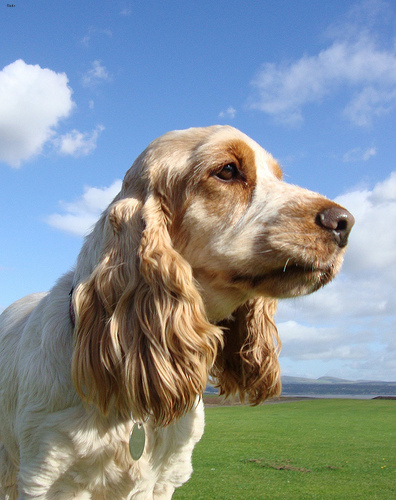

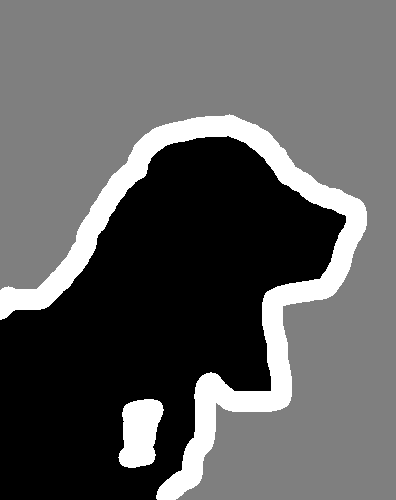

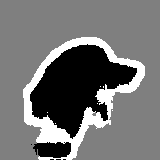

In [22]:
display(Image(filename=val_input_img_paths[500]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[500]))
display(img)

#predict
display_mask(500)